In [50]:
import sys
import os
workspace_path = os.path.join(os.path.abspath(".."))
sys.path.append(workspace_path)
workspace_path

'c:\\Code\\job_discrimination'

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import re
import warnings
warnings.simplefilter("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import tree, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from pandas.core.frame import DataFrame

In [52]:
pd.options.display.float_format = "{:.2f}".format

In [53]:
# Reading application statistics into dataframe
filepath = os.path.join(workspace_path, "data", "cleaned_data", "bulletins_w_labels_and_content.csv")
df = pd.read_csv(filepath)
df

,Unnamed: 0.1,Unnamed: 0,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Label,Text,Cleaned text
0,0,0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt,M,311 DIRECTOR Class Code: 9206 Open Date:...,director class code open date annual salary du...
1,1,1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt,W,ACCOUNTING CLERK Class Code: 1223 Open ...,accounting clerk class code open date exam ope...
2,2,2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt,M,AIRPORT MANAGER Class Code: 7260 Open D...,airport manager class code open date exam open...
3,3,3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt,M,AIRPORT POLICE LIEUTENANT ...,airport police lieutenant class code open date...
4,4,4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt,M,AQUARIST Class Code: 2400 Open Date: 05...,aquarist class code open date annual salary ca...
...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,M,WASTEWATER TREATMENT LABORATORY MANAGER Class...,wastewater treatment laboratory manager class ...
173,173,173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt,M,WASTEWATER TREATMENT OPERATOR Class Code: ...,wastewater treatment operator class code open ...
174,174,174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,N,WATER MICROBIOLOGIST Class Code: 7857...,water microbiologist class code open date revi...
175,175,175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt,M,WATER UTILITY WORKER Class Code: 3912 Op...,water utility worker class code open date exam...


In [ ]:
df = df.drop("Label", axis=1)

In [95]:
# Create and add labels
mostly_women = df["Female"] >= (df["Apps Received"] - df["Unknown_Gender"]) * 0.7
mostly_men = df["Male"] >= (df["Apps Received"] - df["Unknown_Gender"]) * 0.7
neutral = (df["Female"] < (df["Apps Received"] - df["Unknown_Gender"]) * 0.7) & (df["Female"] > (df["Apps Received"] - df["Unknown_Gender"]) * 0.3)

KeyError: 'Female'

In [60]:
labels = []
for i in range(len(df)):
    if mostly_women[i]:
        label = "W"
    elif mostly_men[i]:
        label = "M"
    elif neutral[i]:
        label = "N"
    else:
        label = None
    labels.append(label)
df["Label"] = labels
df

,Unnamed: 0.1,Unnamed: 0,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Text,Cleaned text,Label
0,0,0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt,311 DIRECTOR Class Code: 9206 Open Date:...,director class code open date annual salary du...,N
1,1,1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt,ACCOUNTING CLERK Class Code: 1223 Open ...,accounting clerk class code open date exam ope...,W
2,2,2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt,AIRPORT MANAGER Class Code: 7260 Open D...,airport manager class code open date exam open...,M
3,3,3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt,AIRPORT POLICE LIEUTENANT ...,airport police lieutenant class code open date...,M
4,4,4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt,AQUARIST Class Code: 2400 Open Date: 05...,aquarist class code open date annual salary ca...,N
...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,WASTEWATER TREATMENT LABORATORY MANAGER Class...,wastewater treatment laboratory manager class ...,N
173,173,173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt,WASTEWATER TREATMENT OPERATOR Class Code: ...,wastewater treatment operator class code open ...,M
174,174,174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,WATER MICROBIOLOGIST Class Code: 7857...,water microbiologist class code open date revi...,N
175,175,175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt,WATER UTILITY WORKER Class Code: 3912 Op...,water utility worker class code open date exam...,M


In [62]:
df["Label"].value_counts()

M    105
N     62
W     10
Name: Label, dtype: int64

In [63]:
df.dropna(how="any", inplace=True)
df.reset_index(inplace=True, drop=True)
df.drop(columns=["Apps Received", "Female", "Male", "Unknown_Gender"], inplace=True)
df

,Unnamed: 0.1,Unnamed: 0,ID,Job Description,File Names,Text,Cleaned text,Label
0,0,0,9206,311 DIRECTOR,311 DIRECTOR 9206 041814.txt,311 DIRECTOR Class Code: 9206 Open Date:...,director class code open date annual salary du...,N
1,1,1,1223,ACCOUNTING CLERK,ACCOUNTING CLERK 1223 071318.txt,ACCOUNTING CLERK Class Code: 1223 Open ...,accounting clerk class code open date exam ope...,W
2,2,2,7260,AIRPORT MANAGER,AIRPORT MANAGER 7260 120216.txt,AIRPORT MANAGER Class Code: 7260 Open D...,airport manager class code open date exam open...,M
3,3,3,3227,AIRPORT POLICE LIEUTENANT,AIRPORT POLICE LIEUTENANT 3227 091616.txt,AIRPORT POLICE LIEUTENANT ...,airport police lieutenant class code open date...,M
4,4,4,2400,AQUARIST,AQUARIST 2400 050214.txt,AQUARIST Class Code: 2400 Open Date: 05...,aquarist class code open date annual salary ca...,N
...,...,...,...,...,...,...,...,...
172,172,172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,WASTEWATER TREATMENT LABORATORY MANAGER Class...,wastewater treatment laboratory manager class ...,N
173,173,173,4123,WASTEWATER TREATMENT OPERATOR,WASTEWATER TREATMENT OPERATOR 120718.txt,WASTEWATER TREATMENT OPERATOR Class Code: ...,wastewater treatment operator class code open ...,M
174,174,174,7857,WATER MICROBIOLOGIST,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,WATER MICROBIOLOGIST Class Code: 7857...,water microbiologist class code open date revi...,N
175,175,175,3912,WATER UTILITY WORKER,WATER UTILITY WORKER 3912 120817.txt,WATER UTILITY WORKER Class Code: 3912 Op...,water utility worker class code open date exam...,M


In [76]:
df.loc[df['Label'] == "M", 'Label'] = 0
df.loc[df['Label'] == "N", 'Label'] = 1
df.loc[df['Label'] == "W", 'Label'] = 2

df

,Unnamed: 0.1,Unnamed: 0,ID,Job Description,File Names,Text,Cleaned text,Label,First Season
0,0,0,9206,311 DIRECTOR,311 DIRECTOR 9206 041814.txt,311 DIRECTOR Class Code: 9206 Open Date:...,director class code open date annual salary du...,1,1.00
1,1,1,1223,ACCOUNTING CLERK,ACCOUNTING CLERK 1223 071318.txt,ACCOUNTING CLERK Class Code: 1223 Open ...,accounting clerk class code open date exam ope...,2,NaN
2,2,2,7260,AIRPORT MANAGER,AIRPORT MANAGER 7260 120216.txt,AIRPORT MANAGER Class Code: 7260 Open D...,airport manager class code open date exam open...,0,2.00
3,3,3,3227,AIRPORT POLICE LIEUTENANT,AIRPORT POLICE LIEUTENANT 3227 091616.txt,AIRPORT POLICE LIEUTENANT ...,airport police lieutenant class code open date...,0,2.00
4,4,4,2400,AQUARIST,AQUARIST 2400 050214.txt,AQUARIST Class Code: 2400 Open Date: 05...,aquarist class code open date annual salary ca...,1,1.00
...,...,...,...,...,...,...,...,...,...
172,172,172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,WASTEWATER TREATMENT LABORATORY MANAGER Class...,wastewater treatment laboratory manager class ...,1,1.00
173,173,173,4123,WASTEWATER TREATMENT OPERATOR,WASTEWATER TREATMENT OPERATOR 120718.txt,WASTEWATER TREATMENT OPERATOR Class Code: ...,wastewater treatment operator class code open ...,0,2.00
174,174,174,7857,WATER MICROBIOLOGIST,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,WATER MICROBIOLOGIST Class Code: 7857...,water microbiologist class code open date revi...,1,1.00
175,175,175,3912,WATER UTILITY WORKER,WATER UTILITY WORKER 3912 120817.txt,WATER UTILITY WORKER Class Code: 3912 Op...,water utility worker class code open date exam...,0,2.00


In [79]:
X = df["Cleaned text"]
y = df["Label"]

vect = CountVectorizer(stop_words="english")

X = vect.fit_transform(X).todense()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000)

In [80]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

xg_reg = xgb.XGBRegressor(objective="reg:linear", colsample_bytree=0.3,
    learning_rate=0.1, max_depth=5, alpha=10, n_estimators=10)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)



[21:30:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [83]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.511832


In [84]:
params = {"objective": "reg:linear", "colsample_bytree": 0.3, 
    "learning_rate": 0.1, "max_depth": 5, "alpha": 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
    num_boost_round=50, early_stopping_rounds=10, metrics="rmse",
    as_pandas=True, seed=123)

[21:37:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:37:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:37:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [85]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.59,0.02,0.59,0.04
1,0.57,0.02,0.58,0.04
2,0.56,0.01,0.58,0.04
3,0.55,0.01,0.57,0.04
4,0.54,0.01,0.57,0.04


In [86]:
print((cv_results["test-rmse-mean"]).tail(1))

27   0.53
Name: test-rmse-mean, dtype: float64


In [92]:


import os
os.environ["PATH"] += os.pathsep + 'C:\Users\Johanna\anaconda3\Lib\site-packages\sphinx\templates\graphviz'

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3719321468.py, line 2)

In [87]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[21:46:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

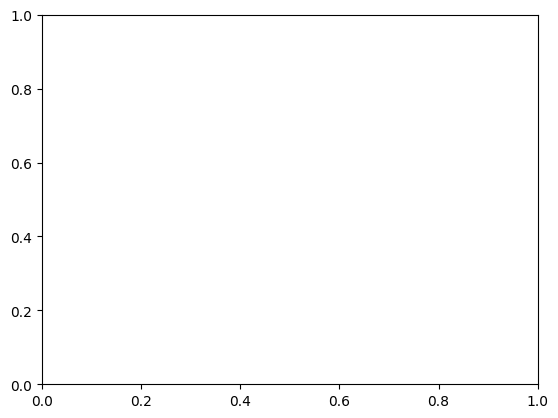

In [91]:
import matplotlib as plt
import graphviz

xgb.plot_tree(xg_reg, num_trees=0)
plt.rcParams["figure.figsize"] = [50, 10]
plt.show()

AttributeError: module 'matplotlib' has no attribute 'show'

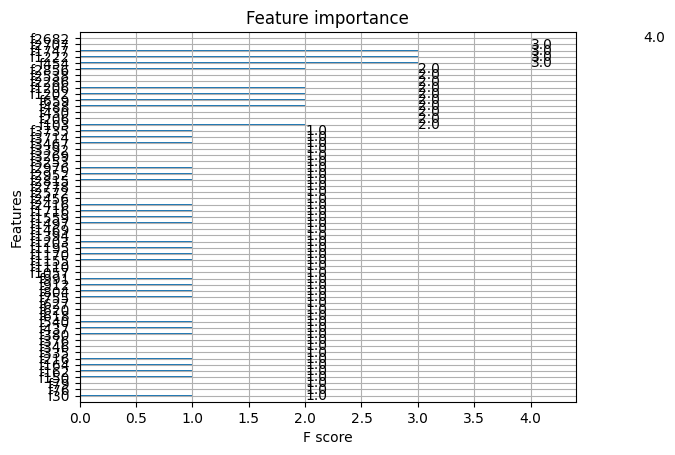

In [93]:
xgb.plot_importance(xg_reg)
plt.rcParams["figure.figsize"] = [5, 5]
plt.show()